#MOGP LMC/ICM

In [1]:
import os
from pathlib import Path 
import sys

os.environ['SUMO_HOME'] = '/Library/Frameworks/EclipseSUMO.framework/Versions/1.24.0/EclipseSUMO/share/sumo'
os.environ['LIBSUMO_AS_TRACI'] = '1' #Optional: for a huge performance boost (~8x) with Libsumo (No GUI)
SUMO_HOME = Path(os.environ['SUMO_HOME'])

if "SUMO_HOME" in os.environ:
    tools = os.path.join(os.environ["SUMO_HOME"], "tools")
    sys.path.append(tools)
else:
    sys.exit("Please declare the environment variable 'SUMO_HOME'")
#import traci





# Add the SUMO *bin* directory to PATH so od2trips/duarouter/sumo are found
# Your SUMO_HOME is .../EclipseSUMO/share/sumo → bin is two levels up, then /bin
SUMO_ROOT = Path(os.environ["SUMO_HOME"]).parents[1]          # .../EclipseSUMO
SUMO_BIN  = str(SUMO_ROOT / "bin") # this convert path to /EclipseSUMO/bin
LIB_SUMO_PATH = Path(os.environ["SUMO_HOME"]).parents[2] / "lib" / "libsumo.dylib"

os.environ["PATH"] = SUMO_BIN + os.pathsep + os.environ.get("PATH", "")

import traci
import sumolib
import json, shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pprint
import seaborn as sns
import torch
from torch.quasirandom import SobolEngine

from botorch import fit_gpytorch_mll
from botorch.acquisition import qLogExpectedImprovement
from botorch.models import SingleTaskGP
from botorch.models.transforms import Standardize
from botorch.optim import optimize_acqf
from botorch.sampling.stochastic_samplers import StochasticSampler
from botorch.utils.transforms import unnormalize, normalize

from gpytorch.constraints import Interval
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models.transforms.outcome import Standardize


base_path = Path("/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn")


if str(base_path ) not in sys.path:
    sys.path.insert(0, str(base_path ))

os.chdir(base_path )

from helpers_od_calibration_BN import load_kwargs_config
from src.simulation.data_loader import od_xml_to_df
from src.simulation.evaluation import parse_loop_data_xml_to_pandas
from src.simulation.sumo_runner import create_taz_xml, simulate_od
from src.utils.link_flow_analysis import (
    compute_squared_metric_all_edge as compute_nrmse_counts_all_edges,
    compute_squared_metric_per_edge as compute_nrmse_per_edge,
)
%matplotlib inline


config = load_kwargs_config(base_path, "mogp", sim_setup_filename="sim_setup_network_2corridor.json")
Path(config["simulation_run_path"]).mkdir(parents=True, exist_ok=True)
pprint.pprint(dict(config))

/Library/Frameworks/EclipseSUMO.framework/Versions/1.24.0/EclipseSUMO/share/sumo/tools/traci/__init__.py:42: UserWarning: Could not import libsumo using /Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/bin/python, falling back to pure python traci (No module named 'libsumo').
  warnings.warn("Could not import libsumo using %s, falling back to pure python traci (%s)." %


{'BATCH_SIZE': 1,
 'EDGE_OUT_STR': 'edge_data.xml',
 'NITER': 20,
 'NUM_RESTARTS': 16,
 'RAW_SAMPLES': 256,
 'SAMPLE_SHAPE': 64,
 'SUMO_PATH': PosixPath('/Library/Frameworks/EclipseSUMO.framework/Versions/1.24.0/EclipseSUMO/share/sumo'),
 'TRIPS2ODS_OUT_STR': 'trips.xml',
 'additional_xml': PosixPath('/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml'),
 'file_gt_od': PosixPath('/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/od.xml'),
 'fixed_routes': PosixPath('/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/routes_single.csv'),
 'model_name': 'mogp',
 'n_init_search': 20,
 'net_xml': PosixPath('/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml'),
 'network_name': 'network_2corridor',
 'network_path': PosixPath('network/network_2corridor'),
 'od_duration_sec': 3600,
 'sim_end_time': 3900,
 'sim_start_time': 0,
 'sim_stat_freq_sec': 300,
 'simulation_r

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# create GT scenario 

In [2]:
# Get Ground Truth OD + fixed routes
print(f"Reading: {config['file_gt_od']}")
gt_od_df = od_xml_to_df(config["file_gt_od"])

print(f"Reading: {config['fixed_routes']}")
routes_df = pd.read_csv(config["fixed_routes"], index_col=0)



Reading: /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/od.xml
Total GT demand: 23261.0
Reading: /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/routes_single.csv


In [3]:
simulation_gt_run_path =f'{config["simulation_run_path"]}/ground_truth'
prefix_output_gt = f'{simulation_gt_run_path}/sim'
sim_edge_out_gt = f'{prefix_output_gt}_{config["EDGE_OUT_STR"]}'
new_od_xml = f'{simulation_gt_run_path}/od.xml'

Path(simulation_gt_run_path).mkdir(parents=True, exist_ok=True)

base_od = gt_od_df.copy()
gt_od_vals = gt_od_df['count'].astype(float).to_numpy()
curr_od = gt_od_vals.copy()
base_od['count'] = curr_od
base_od = base_od.rename(columns={'fromTaz':'from', 'toTaz':'to'})
create_taz_xml(new_od_xml, base_od, config["od_duration_sec"], base_path)

print(base_od)


# Run simulation
simulate_od(new_od_xml,
            prefix_output_gt,
            base_path,
            config["net_xml"],
            config["taz2edge_xml"],
            config["additional_xml"],
            routes_df,
            config["sim_end_time"],
            config["TRIPS2ODS_OUT_STR"])

Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_mogp/ground_truth/od.xml
      from      to   count
0    taz_0   taz_1   148.0
1    taz_0  taz_60   440.0
2    taz_0  taz_61   923.0
3    taz_0  taz_62  1489.0
4    taz_0  taz_63  1620.0
5    taz_0  taz_64   586.0
6   taz_60   taz_1  1258.0
7   taz_60  taz_61  1929.0
8   taz_60  taz_62  1890.0
9   taz_60  taz_63  1213.0
10  taz_60  taz_64  1200.0
11  taz_61   taz_1  1866.0
12  taz_61  taz_62  1784.0
13  taz_61  taz_63  1411.0
14  taz_61  taz_64  1041.0
15  taz_62   taz_1   479.0
16  taz_62  taz_63   528.0
17  taz_62  taz_64   275.0
18  taz_63   taz_1  1306.0
19  taz_63  taz_64  1024.0
20  taz_64   taz_1   851.0
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/network_2corridor_mogp/ground_truth/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_mogp/ground_trut

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (4ms ~= 250.00*RT, ~315750.00UPS, vehicles TOT 12105 ACT 1263 BUF 11156)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 8.94s
 Real time factor: 436.095
 UPS: 541151.738790
Vehicles:
 Inserted: 12105 (Loaded: 23261)
 Running: 1263
 Waiting: 11156
Statistics (avg of 10842):
 RouteLength: 3400.06
 Speed: 13.97
 Duration: 353.52
 WaitingTime: 1.51
 TimeLoss: 208.99
 DepartDelay: 295.38
DijkstraRouter answered 28380 queries and explored 22.41 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).


In [20]:
df_edge_gt, df_trips_raw, out_csv = parse_loop_data_xml_to_pandas(
    base_path,
    sim_edge_out_gt,   # '.../ground_truth/sim_edge_data_quickstart.xml'
    prefix_output_gt,  # '.../ground_truth/sim'
    config["SUMO_PATH"],
)

print(df_edge_gt.head(70))
print(df_trips_raw.columns)

num_gt_edges = df_edge_gt.shape[0]
print("Number of GT edges:",num_gt_edges)


                       edge_id  interval_nVehContrib  \
0                     11531386                  2244   
1                    394165856                  1963   
2                    394165857                   851   
3                    394170678                  1917   
4                  394170681#0                  1914   
5                    395318356                  4101   
6                    395358019                   276   
7                  416220210#0                  2240   
8                    417524818                  1923   
9                    456092814                  2312   
10                 456092817#0                  2321   
11                   479773094                  3889   
12                   479773095                  3753   
13  479773095-AddedOffRampEdge                  3746   
14                   479773096                  6368   
15  479773096-AddedOffRampEdge                  6348   
16                   479773097                  

In [21]:
# List edges with NO GT flow (not present in df_edge_gt)
net = sumolib.net.readNet(str(config["net_xml"]))
all_edge_ids = [edge.getID() for edge in net.getEdges()]

gt_edge_ids = set(df_edge_gt["edge_id"].tolist())
missing_edges = [e for e in all_edge_ids if e not in gt_edge_ids]

print(f"Edges with NO GT data: {len(missing_edges)}")
print(missing_edges)

Edges with NO GT data: 17
['13117724', '13143644#0', '13143656#0', '13143660', '395307310#1', '417523573', '456092806', '456097810#0', '509747227', '509747230', '509747284', '517246480', '517296940', '517296941', '8924896', '9331721', '9547901']


In [22]:
gt_edge_data = df_edge_gt \
    .sort_values(by=['interval_nVehContrib'], ascending=False) \
    .iloc[:num_gt_edges]

print(sim_edge_out_gt)

edge_ids = gt_edge_data["edge_id"].tolist()

gt_flows = (
    gt_edge_data.set_index("edge_id")
    .loc[edge_ids, "interval_nVehContrib"]
    .values.astype(float)
)

L = len(edge_ids)
weights_np = np.ones(L) / L

print("Using UNIFORM weights:")
for e, w in zip(edge_ids, weights_np):
    print(f"  {e}: weight = {w:.4f}")

output/network_2corridor_mogp/ground_truth/sim_edge_data.xml
Using UNIFORM weights:
  479773097-AddedOnRampEdge: weight = 0.0196
  867204830-AddedOnRampEdge: weight = 0.0196
  867204830: weight = 0.0196
  867204830-AddedOffRampEdge: weight = 0.0196
  479773097: weight = 0.0196
  479773096: weight = 0.0196
  479773096-AddedOffRampEdge: weight = 0.0196
  509747331: weight = 0.0196
  867204829: weight = 0.0196
  509747295: weight = 0.0196
  509747288: weight = 0.0196
  509747324: weight = 0.0196
  687721986: weight = 0.0196
  509747324-AddedOnRampEdge: weight = 0.0196
  395318356: weight = 0.0196
  8954447: weight = 0.0196
  617259144-AddedOnRampEdge: weight = 0.0196
  479773094: weight = 0.0196
  617259144: weight = 0.0196
  479773095: weight = 0.0196
  479773095-AddedOffRampEdge: weight = 0.0196
  509747233-AddedOnRampEdge: weight = 0.0196
  509747233: weight = 0.0196
  8925009: weight = 0.0196
  456092817#0: weight = 0.0196
  456092814: weight = 0.0196
  11531386: weight = 0.0196
  416

In [23]:
print (L)

51


In [6]:
print ("GT flows :", gt_flows[:])
print ("Weights :", weights_np[:])

GT flows : [6550. 6498. 6489. 6487. 6462. 6368. 6348. 5206. 5117. 5117. 5111. 4766.
 4766. 4766. 4101. 3897. 3890. 3889. 3799. 3753. 3746. 2955. 2937. 2330.
 2321. 2312. 2244. 2240. 2104. 1963. 1949. 1923. 1917. 1914. 1800. 1799.
 1797. 1760. 1751. 1733. 1548. 1531. 1516. 1362.  851.  851.  851.  440.
  302.  276.  237.]
Weights : [0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784]


# sobol points 

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
dtype = torch.double

dim_od = gt_od_df.shape[0]
print(dim_od)

bounds = torch.tensor([
    [ 0 for _ in range(dim_od)],
    [ 2000 for _ in range(dim_od)]
], device=device, dtype=dtype)



seed = 42  

torch.manual_seed(seed)

np.random.seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

print(f"Random seed set to {seed}")



sobol = SobolEngine(dim_od, scramble=True, seed = seed) #Sobol sequences are an example of low discrepancy quasi-random sequences.
#using seed for reproducibility
x_0 = sobol.draw(config["n_init_search"]).to(dtype=dtype).to(device) # generate n_init_search samples, here 5
print (x_0.shape)
#x_0 shape: torch.Size([5, 4]) meaning 5 samples of 4 dimensions each
# map the normalized into the original parameter space
train_X0 = unnormalize(x_0, bounds)
print (train_X0)  #15 samples of 4 dimensions each


print (dim_od)
#4 dimension, 4OD pairs
#so we have 4 pairs so 4 demand values to optimize

cpu
21
Random seed set to 42
torch.Size([20, 21])
tensor([[1995.0267,  208.7328, 1645.9577,  838.8643, 1056.6442,  112.4814,
          910.5846, 1498.4061,  442.1483, 1235.3967, 1620.1895,  424.5811,
           76.8722, 1763.6480, 1301.2593, 1333.1703, 1641.8632, 1193.1571,
          472.6151, 1613.9487,  334.2874],
        [  57.3551, 1496.5136,  224.1529, 1034.3661,   68.6411, 1638.0646,
         1126.1221,  371.2380, 1489.2815,  275.1244,  427.1543, 1754.9608,
         1361.3771,  688.0627,  422.7808,  381.8277,  870.4802,  384.3589,
         1190.8222,  718.8758, 1254.2589],
        [ 802.7174,  560.0206, 1008.2554,  332.2719,  831.8899, 1257.5989,
          222.3803,  637.7038, 1993.9388,  556.7673,  973.7991, 1018.7044,
          889.5292, 1128.8687,  831.6194, 1833.3936,  423.0999, 1505.8671,
         1656.2229, 1015.0840,  790.3093],
        [1239.9006, 1770.1647,  617.7125, 1544.8638, 1796.4624,  993.6885,
         1944.2205, 1515.1131,  945.3723, 1955.6307, 1042.3532,  661.09

## evaluation of Sobol points

In [ ]:

train_X_list = []      # list of input od
train_E_list = []      # per-edge errors
S_list       = []      # scalar aggregated loss

batch_data_i = []      
 

for i, x in enumerate(train_X0.tolist()):
    print(f"Initial OD: {i}")
    curr_od = np.array(x, dtype=float)
    print(curr_od)
    print(f"total expected demand: {np.sum(curr_od)}")

    
    simulation_run_path_init = f"{config['simulation_run_path']}/initial_search"
    Path(simulation_run_path_init).mkdir(parents=True, exist_ok=True)

    # OD xml for this candidate 
    new_od_xml = f"{simulation_run_path_init}/gt_od_{config['network_name']}_{i}.xml"
    prefix_output_base = f"{simulation_run_path_init}/sobol_{i}"

    # build OD xml 
    base_od = gt_od_df.copy()
    base_od["count"] = curr_od
    base_od["count"] = [round(v, 1) for v in base_od["count"]]
    base_od = base_od.rename(columns={"fromTaz": "from", "toTaz": "to"})
    create_taz_xml(new_od_xml, base_od, config["od_duration_sec"], base_path)



    per_edge_errors_reps = []

    for rep in range("BO_num_restarts"):
        print(f" restart {rep}")
        prefix_output_rep = f"{prefix_output_base}_rep{rep}"

        simulate_od(
            new_od_xml,
            prefix_output_rep,
            base_path,
            config["net_xml"],
            config["taz2edge_xml"],
            config["additional_xml"],
            routes_df,
            config["sim_end_time"],
            config["TRIPS2ODS_OUT_STR"],
            sim_start_time=0,
            seed=rep,  
        )

        sim_edge_out_rep = f"{prefix_output_rep}_{config['EDGE_OUT_STR']}"
        curr_loop_stats_rep, _, _ = parse_loop_data_xml_to_pandas(
            base_path,
            sim_edge_out_rep,
            prefix_output_rep,
            config["SUMO_PATH"],
        )

        # print simulated flows per edge
        sim_counts = ( 
            curr_loop_stats_rep[curr_loop_stats_rep["edge_id"].isin(edge_ids)]
            .set_index("edge_id")["interval_nVehContrib"]
            .loc[edge_ids]  # preserve order
            .values
        )

        print(f"\Simulated flows for replication {rep} ")
        for edge_id, count in zip(edge_ids, sim_counts):
            print(f"  {edge_id}: {count}")

        # per-edge error for this replication (e_l(x))
        per_edge_errors_rep = compute_nrmse_per_edge(
            df_true=gt_edge_data,
            df_simulated=curr_loop_stats_rep,
            edge_ids=edge_ids,
        )  # np.array [L]

        per_edge_errors_reps.append(per_edge_errors_rep)


    per_edge_errors_reps = np.stack(per_edge_errors_reps, axis=0)  # [N_REP, L]
    per_edge_errors = per_edge_errors_reps.mean(axis=0)            # [L]

    # aggregated scalar loss S(x) = Σ_l w_l e_l(x)
    S_x = float((per_edge_errors * weights_np).sum())
    print(f"aggregated loss S(x): {S_x} ")

    train_X_list.append(curr_od.copy())
    train_E_list.append(per_edge_errors.copy())
    S_list.append(S_x)

   
   
    df_curr = pd.DataFrame(
        curr_od.reshape(1, -1),
        columns=[f"x_{k+1}" for k in range(curr_od.shape[0])]
    )
    df_curr["loss"] = S_x
    batch_data_i.append(df_curr)

# save initial dataset
df_initial_bo = pd.concat(batch_data_i, ignore_index=True)
df_initial_bo.to_csv(
    f"{config['simulation_run_path']}/initial_search/data_set_ods_icm_replicated.csv",
    index=False,
)
print("Saved replicated initial ICM dataset")

########### Initial OD: 0 ###########
[1995.02670765  208.73278379 1645.95770836  838.86432648 1056.64420128
  112.48141527  910.58456898 1498.40605259  442.14826822 1235.39674282
 1620.18954754  424.58114028   76.87224448 1763.64803314 1301.25927925
 1333.17029476 1641.86322689 1193.15707684  472.61509299 1613.94870281
  334.28743482]
total expected demand: 21719.834849238396
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_mogp/initial_search/gt_od_network_2corridor_0.xml
    ▶ Replication 0
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/network_2corridor_mogp/initial_search/gt_od_network_2corridor_0.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_mogp/initial_search/sobol_0_rep0_trips_beforeRteUpdates.xml
Success.time 3598.88
Running SUMO: sumo --output-prefix output/network_2corridor_mogp/initial_search

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (7ms ~= 142.86*RT, ~156857.14UPS, vehicles TOT 11188 ACT 1098 BUF 10531)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 8.14s
 Real time factor: 479.351
 UPS: 601834.439528
Vehicles:
 Inserted: 11188 (Loaded: 21719)
 Running: 1098
 Waiting: 10531
Statistics (avg of 10090):
 RouteLength: 4183.02
 Speed: 12.94
 Duration: 411.34
 WaitingTime: 2.23
 TimeLoss: 242.68
 DepartDelay: 335.61
DijkstraRouter answered 26051 queries and explored 24.07 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).

--- Simulated flows for replication 0 ---
  479773097-AddedOnRampEdge: 6689
  867204830-AddedOnRampEdge: 7425
  867204830: 7417
  867204830-AddedOffRampEdge: 7415
  479773097: 6680
  479773096: 6601
  479773096-AddedOffRampEdge: 6579
  509747331: 5858
  867204829: 5301
  509747295: 5301
  509747288: 5297
  509747324: 5649
  687721986: 5649
  509747324-AddedOnRampEdge: 5649
  395318356: 4

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (2ms ~= 500.00*RT, ~782500.00UPS, vehicles TOT 11555 ACT 1565 BUF 5682)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 4.49s
 Real time factor: 868.597
 UPS: 1117498.663697
Vehicles:
 Inserted: 11555 (Loaded: 17237)
 Running: 1565
 Waiting: 5682
Statistics (avg of 9990):
 RouteLength: 3301.21
 Speed: 12.76
 Duration: 386.21
 WaitingTime: 1.30
 TimeLoss: 245.82
 DepartDelay: 281.26
DijkstraRouter answered 21539 queries and explored 22.59 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).

--- Simulated flows for replication 0 ---
  479773097-AddedOnRampEdge: 6487
  867204830-AddedOnRampEdge: 4825
  867204830: 4817
  867204830-AddedOffRampEdge: 4815
  479773097: 6478
  479773096: 6468
  479773096-AddedOffRampEdge: 6465
  509747331: 4518
  867204829: 4406
  509747295: 4405
  509747288: 4401
  509747324: 3021
  687721986: 3021
  509747324-AddedOnRampEdge: 3021
  395318356: 36

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (4ms ~= 250.00*RT, ~471500.00UPS, vehicles TOT 10901 ACT 1886 BUF 9371)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 6.31s
 Real time factor: 617.675
 UPS: 980124.485271
Vehicles:
 Inserted: 10901 (Loaded: 20272)
 Running: 1886
 Waiting: 9371
Statistics (avg of 9015):
 RouteLength: 3729.93
 Speed: 12.29
 Duration: 521.32
 WaitingTime: 1.83
 TimeLoss: 365.96
 DepartDelay: 317.48
DijkstraRouter answered 25049 queries and explored 22.19 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).

--- Simulated flows for replication 0 ---
  479773097-AddedOnRampEdge: 6215
  867204830-AddedOnRampEdge: 5975
  867204830: 5966
  867204830-AddedOffRampEdge: 5965
  479773097: 6152
  479773096: 5897
  479773096-AddedOffRampEdge: 5848
  509747331: 4793
  867204829: 4700
  509747295: 4692
  509747288: 4633
  509747324: 4233
  687721986: 4233
  509747324-AddedOnRampEdge: 4233
  395318356: 373

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (4ms ~= 250.00*RT, ~365250.00UPS, vehicles TOT 14213 ACT 1461 BUF 11528)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 9.07s
 Real time factor: 430.036
 UPS: 592112.250524
Vehicles:
 Inserted: 14213 (Loaded: 25741)
 Running: 1461
 Waiting: 11528
Statistics (avg of 12752):
 RouteLength: 3614.68
 Speed: 13.67
 Duration: 350.36
 WaitingTime: 1.54
 TimeLoss: 202.22
 DepartDelay: 267.40
DijkstraRouter answered 32266 queries and explored 24.38 edges on average.
DijkstraRouter spent 0.05s answering queries (0.00ms on average).

--- Simulated flows for replication 0 ---
  479773097-AddedOnRampEdge: 7627
  867204830-AddedOnRampEdge: 7256
  867204830: 6968
  867204830-AddedOffRampEdge: 6960
  479773097: 7587
  479773096: 7562
  479773096-AddedOffRampEdge: 7554
  509747331: 7577
  867204829: 6085
  509747295: 6083
  509747288: 6056
  509747324: 5723
  687721986: 5786
  509747324-AddedOnRampEdge: 5741
  395318356: 4

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (2ms ~= 500.00*RT, ~728500.00UPS, vehicles TOT 11690 ACT 1457 BUF 9189)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 5.62s
 Real time factor: 693.95
 UPS: 938617.259786
Vehicles:
 Inserted: 11690 (Loaded: 20879)
 Running: 1457
 Waiting: 9189
Statistics (avg of 10233):
 RouteLength: 3797.06
 Speed: 10.65
 Duration: 454.50
 WaitingTime: 2.38
 TimeLoss: 298.85
 DepartDelay: 373.62
DijkstraRouter answered 26923 queries and explored 22.46 edges on average.
DijkstraRouter spent 0.03s answering queries (0.00ms on average).

--- Simulated flows for replication 0 ---
  479773097-AddedOnRampEdge: 6798
  867204830-AddedOnRampEdge: 6776
  867204830: 6648
  867204830-AddedOffRampEdge: 6616
  479773097: 6772
  479773096: 6684
  479773096-AddedOffRampEdge: 6669
  509747331: 6474
  867204829: 5909
  509747295: 5907
  509747288: 5803
  509747324: 5417
  687721986: 5486
  509747324-AddedOnRampEdge: 5483
  395318356: 428

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (6ms ~= 166.67*RT, ~487500.00UPS, vehicles TOT 12478 ACT 2925 BUF 12554)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 9.06s
 Real time factor: 430.369
 UPS: 884053.299492
Vehicles:
 Inserted: 12478 (Loaded: 25032)
 Running: 2925
 Waiting: 12554
Statistics (avg of 9553):
 RouteLength: 3055.83
 Speed: 11.14
 Duration: 518.22
 WaitingTime: 1.99
 TimeLoss: 387.89
 DepartDelay: 236.94
DijkstraRouter answered 30066 queries and explored 22.36 edges on average.
DijkstraRouter spent 0.07s answering queries (0.00ms on average).

--- Simulated flows for replication 0 ---
  479773097-AddedOnRampEdge: 4901
  867204830-AddedOnRampEdge: 6073
  867204830: 5813
  867204830-AddedOffRampEdge: 5785
  479773097: 4795
  479773096: 4578
  479773096-AddedOffRampEdge: 4567
  509747331: 6541
  867204829: 3812
  509747295: 3796
  509747288: 3596
  509747324: 4571
  687721986: 4642
  509747324-AddedOnRampEdge: 4612
  395318356: 33

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (2ms ~= 500.00*RT, ~1434500.00UPS, vehicles TOT 10764 ACT 2869 BUF 4238)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 2.65s
 Real time factor: 1470.59
 UPS: 2151295.625943
Vehicles:
 Inserted: 10764 (Loaded: 15002)
 Running: 2869
 Waiting: 4238
Statistics (avg of 7895):
 RouteLength: 3487.14
 Speed: 15.32
 Duration: 332.90
 WaitingTime: 0.78
 TimeLoss: 184.81
 DepartDelay: 229.43
DijkstraRouter answered 17764 queries and explored 24.38 edges on average.
DijkstraRouter spent 0.02s answering queries (0.00ms on average).

--- Simulated flows for replication 0 ---
  479773097-AddedOnRampEdge: 6044
  867204830-AddedOnRampEdge: 5996
  867204830: 5988
  867204830-AddedOffRampEdge: 5972
  479773097: 5861
  479773096: 5597
  479773096-AddedOffRampEdge: 5537
  509747331: 4494
  867204829: 4416
  509747295: 4400
  509747288: 4184
  509747324: 4216
  687721986: 4216
  509747324-AddedOnRampEdge: 4216
  395318356: 32

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (1ms ~= 1000.00*RT, ~1545000.00UPS, vehicles TOT 13121 ACT 1545 BUF 8446)   
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 4.93s
 Real time factor: 791.075
 UPS: 1190164.097363
Vehicles:
 Inserted: 13121 (Loaded: 21567)
 Running: 1545
 Waiting: 8446
Statistics (avg of 11576):
 RouteLength: 3644.05
 Speed: 13.62
 Duration: 408.56
 WaitingTime: 1.82
 TimeLoss: 259.58
 DepartDelay: 150.69
DijkstraRouter answered 26058 queries and explored 23.24 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).

--- Simulated flows for replication 0 ---
  479773097-AddedOnRampEdge: 6444
  867204830-AddedOnRampEdge: 6829
  867204830: 6745
  867204830-AddedOffRampEdge: 6737
  479773097: 6317
  479773096: 6291
  479773096-AddedOffRampEdge: 6264
  509747331: 6581
  867204829: 5208
  509747295: 5206
  509747288: 5177
  509747324: 5430
  687721986: 5504
  509747324-AddedOnRampEdge: 5494
  395318356: 4

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (2ms ~= 500.00*RT, ~711000.00UPS, vehicles TOT 10552 ACT 1422 BUF 7240)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 4.99s
 Real time factor: 781.094
 UPS: 973540.356499
Vehicles:
 Inserted: 10552 (Loaded: 17792)
 Running: 1422
 Waiting: 7240
Statistics (avg of 9130):
 RouteLength: 3951.87
 Speed: 13.29
 Duration: 439.75
 WaitingTime: 1.61
 TimeLoss: 277.31
 DepartDelay: 328.92
DijkstraRouter answered 22520 queries and explored 21.81 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).

--- Simulated flows for replication 0 ---
  479773097-AddedOnRampEdge: 6561
  867204830-AddedOnRampEdge: 5546
  867204830: 5537
  867204830-AddedOffRampEdge: 5536
  479773097: 6552
  479773096: 6436
  479773096-AddedOffRampEdge: 6426
  509747331: 4426
  867204829: 4443
  509747295: 4442
  509747288: 4438
  509747324: 3742
  687721986: 3742
  509747324-AddedOnRampEdge: 3742
  395318356: 422

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (5ms ~= 200.00*RT, ~459200.00UPS, vehicles TOT 13677 ACT 2296 BUF 13325)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 10.84s
 Real time factor: 359.878
 UPS: 641884.285319
Vehicles:
 Inserted: 13677 (Loaded: 27002)
 Running: 2296
 Waiting: 13325
Statistics (avg of 11381):
 RouteLength: 3289.87
 Speed: 12.32
 Duration: 469.15
 WaitingTime: 1.85
 TimeLoss: 331.40
 DepartDelay: 247.68
DijkstraRouter answered 32897 queries and explored 23.48 edges on average.
DijkstraRouter spent 0.06s answering queries (0.00ms on average).

--- Simulated flows for replication 0 ---
  479773097-AddedOnRampEdge: 6570
  867204830-AddedOnRampEdge: 7185
  867204830: 6950
  867204830-AddedOffRampEdge: 6944
  479773097: 6451
  479773096: 6372
  479773096-AddedOffRampEdge: 6312
  509747331: 7384
  867204829: 5330
  509747295: 5328
  509747288: 5265
  509747324: 5487
  687721986: 5593
  509747324-AddedOnRampEdge: 5553
  395318356: 

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (2ms ~= 500.00*RT, ~1794500.00UPS, vehicles TOT 8344 ACT 3589 BUF 9421)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 3.31s
 Real time factor: 1176.83
 UPS: 3074616.475558
Vehicles:
 Inserted: 8344 (Loaded: 17765)
 Running: 3589
 Waiting: 9421
Statistics (avg of 4755):
 RouteLength: 2813.62
 Speed: 10.62
 Duration: 436.30
 WaitingTime: 0.91
 TimeLoss: 305.27
 DepartDelay: 109.20
DijkstraRouter answered 21219 queries and explored 23.35 edges on average.
DijkstraRouter spent 0.03s answering queries (0.00ms on average).

--- Simulated flows for replication 0 ---
  479773097-AddedOnRampEdge: 3406
  867204830-AddedOnRampEdge: 3988
  867204830: 3692
  867204830-AddedOffRampEdge: 3632
  479773097: 3229
  479773096: 3008
  479773096-AddedOffRampEdge: 2948
  509747331: 3518
  867204829: 2927
  509747295: 2911
  509747288: 2695
  509747324: 3059
  687721986: 3208
  509747324-AddedOnRampEdge: 3125
  395318356: 223

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (3ms ~= 333.33*RT, ~431666.67UPS, vehicles TOT 14660 ACT 1295 BUF 7052)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 4.89s
 Real time factor: 798.199
 UPS: 1087325.010233
Vehicles:
 Inserted: 14660 (Loaded: 21712)
 Running: 1295
 Waiting: 7052
Statistics (avg of 13365):
 RouteLength: 3391.59
 Speed: 14.61
 Duration: 329.61
 WaitingTime: 1.45
 TimeLoss: 189.42
 DepartDelay: 168.06
DijkstraRouter answered 26475 queries and explored 23.04 edges on average.
DijkstraRouter spent 0.02s answering queries (0.00ms on average).

--- Simulated flows for replication 0 ---
  479773097-AddedOnRampEdge: 6975
  867204830-AddedOnRampEdge: 7685
  867204830: 7555
  867204830-AddedOffRampEdge: 7548
  479773097: 6860
  479773096: 6831
  479773096-AddedOffRampEdge: 6824
  509747331: 7354
  867204829: 5531
  509747295: 5531
  509747288: 5509
  509747324: 5963
  687721986: 5984
  509747324-AddedOnRampEdge: 5984
  395318356: 4

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (1ms ~= 1000.00*RT, ~2910000.00UPS, vehicles TOT 9788 ACT 2910 BUF 8662)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 3.69s
 Real time factor: 1058.06
 UPS: 2240029.028757
Vehicles:
 Inserted: 9788 (Loaded: 18450)
 Running: 2910
 Waiting: 8662
Statistics (avg of 6878):
 RouteLength: 2960.89
 Speed: 14.20
 Duration: 440.50
 WaitingTime: 0.93
 TimeLoss: 308.82
 DepartDelay: 125.75
DijkstraRouter answered 22897 queries and explored 21.50 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).

--- Simulated flows for replication 0 ---
  479773097-AddedOnRampEdge: 3651
  867204830-AddedOnRampEdge: 4513
  867204830: 4179
  867204830-AddedOffRampEdge: 4119
  479773097: 3471
  479773096: 3225
  479773096-AddedOffRampEdge: 3165
  509747331: 4146
  867204829: 2752
  509747295: 2736
  509747288: 2520
  509747324: 3364
  687721986: 3517
  509747324-AddedOnRampEdge: 3430
  395318356: 312

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (2ms ~= 500.00*RT, ~898500.00UPS, vehicles TOT 12287 ACT 1797 BUF 7967)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 5.34s
 Real time factor: 730.2
 UPS: 1158222.430257
Vehicles:
 Inserted: 12287 (Loaded: 20254)
 Running: 1797
 Waiting: 7967
Statistics (avg of 10490):
 RouteLength: 3810.10
 Speed: 11.71
 Duration: 487.89
 WaitingTime: 2.58
 TimeLoss: 332.25
 DepartDelay: 179.94
DijkstraRouter answered 25385 queries and explored 25.55 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).

--- Simulated flows for replication 0 ---
  479773097-AddedOnRampEdge: 6513
  867204830-AddedOnRampEdge: 6222
  867204830: 5949
  867204830-AddedOffRampEdge: 5939
  479773097: 6488
  479773096: 6307
  479773096-AddedOffRampEdge: 6247
  509747331: 6302
  867204829: 5230
  509747295: 5228
  509747288: 5164
  509747324: 5041
  687721986: 5099
  509747324-AddedOnRampEdge: 5092
  395318356: 422

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (4ms ~= 250.00*RT, ~709250.00UPS, vehicles TOT 11802 ACT 2837 BUF 16188)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 9.99s
 Real time factor: 390.508
 UPS: 800135.576249
Vehicles:
 Inserted: 11802 (Loaded: 27990)
 Running: 2837
 Waiting: 16188
Statistics (avg of 8965):
 RouteLength: 3063.99
 Speed: 11.29
 Duration: 453.54
 WaitingTime: 1.62
 TimeLoss: 321.29
 DepartDelay: 269.69
DijkstraRouter answered 34824 queries and explored 21.23 edges on average.
DijkstraRouter spent 0.07s answering queries (0.00ms on average).

--- Simulated flows for replication 0 ---
  479773097-AddedOnRampEdge: 4823
  867204830-AddedOnRampEdge: 6294
  867204830: 6007
  867204830-AddedOffRampEdge: 5947
  479773097: 4661
  479773096: 4479
  479773096-AddedOffRampEdge: 4419
  509747331: 6257
  867204829: 4432
  509747295: 4416
  509747288: 4200
  509747324: 5013
  687721986: 5169
  509747324-AddedOnRampEdge: 5079
  395318356: 31

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (1ms ~= 1000.00*RT, ~1086000.00UPS, vehicles TOT 12310 ACT 1086 BUF 5578)   
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 3.97s
 Real time factor: 982.863
 UPS: 1095244.455645
Vehicles:
 Inserted: 12310 (Loaded: 17888)
 Running: 1086
 Waiting: 5578
Statistics (avg of 11224):
 RouteLength: 3658.61
 Speed: 14.72
 Duration: 337.68
 WaitingTime: 1.03
 TimeLoss: 186.63
 DepartDelay: 181.03
DijkstraRouter answered 20422 queries and explored 23.03 edges on average.
DijkstraRouter spent 0.03s answering queries (0.00ms on average).

--- Simulated flows for replication 0 ---
  479773097-AddedOnRampEdge: 6305
  867204830-AddedOnRampEdge: 4772
  867204830: 4764
  867204830-AddedOffRampEdge: 4762
  479773097: 6301
  479773096: 6298
  479773096-AddedOffRampEdge: 6296
  509747331: 4516
  867204829: 4232
  509747295: 4231
  509747288: 4228
  509747324: 2927
  687721986: 2927
  509747324-AddedOnRampEdge: 2927
  395318356: 4

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (7ms ~= 142.86*RT, ~298142.86UPS, vehicles TOT 12782 ACT 2087 BUF 12618)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 10.25s
 Real time factor: 380.451
 UPS: 678761.194030
Vehicles:
 Inserted: 12782 (Loaded: 25400)
 Running: 2087
 Waiting: 12618
Statistics (avg of 10695):
 RouteLength: 4009.47
 Speed: 10.91
 Duration: 551.97
 WaitingTime: 2.46
 TimeLoss: 389.90
 DepartDelay: 353.10
DijkstraRouter answered 33361 queries and explored 25.09 edges on average.
DijkstraRouter spent 0.05s answering queries (0.00ms on average).

--- Simulated flows for replication 0 ---
  479773097-AddedOnRampEdge: 7278
  867204830-AddedOnRampEdge: 7380
  867204830: 7135
  867204830-AddedOffRampEdge: 7109
  479773097: 7249
  479773096: 7223
  479773096-AddedOffRampEdge: 7216
  509747331: 6925
  867204829: 5957
  509747295: 5956
  509747288: 5886
  509747324: 5979
  687721986: 6132
  509747324-AddedOnRampEdge: 6042
  395318356: 

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (0ms ?*RT. ?UPS, vehicles TOT 11189 ACT 695 BUF 6586)                       
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 5.12s
 Real time factor: 762.165
 UPS: 600364.275943
Vehicles:
 Inserted: 11189 (Loaded: 17775)
 Running: 695
 Waiting: 6586
Statistics (avg of 10494):
 RouteLength: 3316.57
 Speed: 14.76
 Duration: 275.11
 WaitingTime: 1.04
 TimeLoss: 133.37
 DepartDelay: 424.11
DijkstraRouter answered 23447 queries and explored 21.10 edges on average.
DijkstraRouter spent 0.05s answering queries (0.00ms on average).

--- Simulated flows for replication 0 ---
  479773097-AddedOnRampEdge: 5520
  867204830-AddedOnRampEdge: 4716
  867204830: 4708
  867204830-AddedOffRampEdge: 4706
  479773097: 5510
  479773096: 5499
  479773096-AddedOffRampEdge: 5497
  509747331: 4424
  867204829: 3208
  509747295: 3208
  509747288: 3204
  509747324: 2922
  687721986: 2922
  509747324-AddedOnRampEdge: 2922
  395318356: 405

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (2ms ~= 500.00*RT, ~584500.00UPS, vehicles TOT 13545 ACT 1169 BUF 9389)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 8.53s
 Real time factor: 457.21
 UPS: 539682.063306
Vehicles:
 Inserted: 13545 (Loaded: 22934)
 Running: 1169
 Waiting: 9389
Statistics (avg of 12376):
 RouteLength: 3320.01
 Speed: 11.69
 Duration: 341.33
 WaitingTime: 1.35
 TimeLoss: 200.84
 DepartDelay: 371.56
DijkstraRouter answered 29652 queries and explored 22.75 edges on average.
DijkstraRouter spent 0.06s answering queries (0.00ms on average).

--- Simulated flows for replication 0 ---
  479773097-AddedOnRampEdge: 5417
  867204830-AddedOnRampEdge: 6525
  867204830: 6358
  867204830-AddedOffRampEdge: 6351
  479773097: 5288
  479773096: 5161
  479773096-AddedOffRampEdge: 5135
  509747331: 5423
  867204829: 4213
  509747295: 4212
  509747288: 4197
  509747324: 4933
  687721986: 4961
  509747324-AddedOnRampEdge: 4946
  395318356: 484

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (1ms ~= 1000.00*RT, ~2816000.00UPS, vehicles TOT 10611 ACT 2816 BUF 7777)   
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 4.36s
 Real time factor: 894.495
 UPS: 1856598.853211
Vehicles:
 Inserted: 10611 (Loaded: 18388)
 Running: 2816
 Waiting: 7777
Statistics (avg of 7795):
 RouteLength: 3700.40
 Speed: 10.61
 Duration: 653.57
 WaitingTime: 2.61
 TimeLoss: 500.24
 DepartDelay: 155.44
DijkstraRouter answered 22594 queries and explored 24.68 edges on average.
DijkstraRouter spent 0.03s answering queries (0.00ms on average).

--- Simulated flows for replication 0 ---
  479773097-AddedOnRampEdge: 5227
  867204830-AddedOnRampEdge: 5159
  867204830: 4997
  867204830-AddedOffRampEdge: 4988
  479773097: 5086
  479773096: 4911
  479773096-AddedOffRampEdge: 4895
  509747331: 5577
  867204829: 4329
  509747295: 4313
  509747288: 4189
  509747324: 3999
  687721986: 4145
  509747324-AddedOnRampEdge: 4058
  395318356: 35

In [9]:
# print the per-edge errors for each sample
print (train_E_list)


[array([4.50346716e-04, 2.03516701e-02, 2.04522176e-02, 2.04648307e-02,
       1.13809648e-03, 1.33876926e-03, 1.32418945e-03, 1.56850845e-02,
       1.29301872e-03, 1.29301872e-03, 1.32438461e-03, 3.43252201e-02,
       3.43252201e-02, 3.43252201e-02, 9.56112964e-03, 1.68358914e-01,
       1.57541650e-01, 1.81538662e-01, 1.81167984e-01, 1.99668243e-01,
       2.00654252e-01, 1.48831457e-03, 1.48029746e-03, 1.91265450e-01,
       2.03878901e-01, 2.10995588e-01, 3.10791344e-01, 3.10408163e-01,
       3.72357920e-02, 2.33561852e-06, 4.21207703e-06, 2.33887671e-03,
       2.35354047e-03, 2.31042454e-03, 7.63681790e-01, 7.65503409e-01,
       7.49761319e-01, 5.42678202e-04, 6.60469452e-04, 6.74260785e-04,
       3.38020552e-03, 5.64215872e-03, 6.37048266e-03, 2.98395078e-01,
       3.69081236e-01, 3.69081236e-01, 3.69081236e-01, 2.75625000e-01,
       7.01723609e-04, 8.40159630e-04, 1.13941854e-03]), array([9.25120914e-05, 6.62876263e-02, 6.63921905e-02, 6.64331354e-02,
       6.13064344e-

In [10]:
print (S_list ) # aggregated losses for each sample trainig OD
print (train_X_list)

[0.1282607298725388, 0.6257545846478675, 0.4672818001852269, 0.3468817324293371, 0.2540341371205709, 0.5257784564761453, 0.13550189665760723, 0.14905911742352787, 1.0675881618031073, 0.9295962081554155, 0.23224930990445264, 0.21615944503828463, 0.33004537408594015, 0.17213438347078905, 0.10113846117923728, 1.1240263237165022, 0.2349388446027014, 0.6746584938161052, 2.7668645046582316, 0.29093490449708204]
[array([1995.02670765,  208.73278379, 1645.95770836,  838.86432648,
       1056.64420128,  112.48141527,  910.58456898, 1498.40605259,
        442.14826822, 1235.39674282, 1620.18954754,  424.58114028,
         76.87224448, 1763.64803314, 1301.25927925, 1333.17029476,
       1641.86322689, 1193.15707684,  472.61509299, 1613.94870281,
        334.28743482]), array([  57.3550947 , 1496.51360512,  224.15287793, 1034.36613083,
         68.64109635, 1638.06462288, 1126.12211704,  371.23799324,
       1489.28153515,  275.12443066,  427.1543324 , 1754.96077538,
       1361.37712002,  688.062

In [11]:
print (curr_od)

[1110.02528667 1228.97434235  485.11564732   97.44542837 1094.35427189
 1867.58351326  153.46121788  403.06162834  178.04926634 1518.69153976
 1164.34633732  229.19684649  508.71479511 1387.78042793 1439.68272209
  972.66685963  789.26897049 1640.41590691 1161.58032417  217.85581112
  737.27476597]


# ICM CLEAN

In [12]:
import torch
import numpy as np
from pathlib import Path
from botorch.utils.transforms import normalize, unnormalize
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf

from MOGP.helpers_MOGP import initialize_icm_gp, LinearAggregationICM


dtype  = torch.float32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_X_icm = torch.tensor(np.array(train_X_list),
                           dtype=dtype, device=device)   # [N, d]

train_Y_icm = torch.tensor(np.array(train_E_list),
                           dtype=dtype, device=device)   # [N, L]

N, d = train_X_icm.shape
L    = train_Y_icm.shape[1]


max_demand = 2000.0
bounds = torch.stack([
    torch.zeros(d, dtype=dtype, device=device),
    torch.full((d,), max_demand, dtype=dtype, device=device),
])

train_X_norm = normalize(train_X_icm, bounds=bounds)



icm_model, mll = initialize_icm_gp(train_X_norm, train_Y_icm)

icm_model     = icm_model.to(device=device, dtype=dtype)
icm_model.likelihood = icm_model.likelihood.to(device=device, dtype=dtype)
mll           = mll.to(device=device, dtype=dtype)

# ============================
# Uniform weights
# ============================
weights_uniform = torch.ones(L, dtype=dtype, device=device)
weights_uniform = weights_uniform / weights_uniform.sum()

# ============================
# Aggregation model S(x)
# ============================
agg_model = LinearAggregationICM(icm_model, weights_uniform).to(device=device, dtype=dtype)

# ============================
# Fit initial ICM GP
# ============================
icm_model.train()
mll.train()

fit_gpytorch_mll(mll)   # jitter applied automatically if needed

print("Initial ICM fit done.")

Initial ICM fit done.


In [13]:

S_all = (train_Y_icm * weights_uniform).sum(dim=1)

best_S = S_all.min().item()

print("Initial S values:", S_all.cpu().numpy())
print(f"Initial best S = {best_S:.6f}")

S_history     = [best_S]
S_obs_history = S_all.cpu().tolist()

Initial S values: [0.12826073 0.6257546  0.46728182 0.34688175 0.25403416 0.52577853
 0.1355019  0.14905913 1.0675882  0.9295963  0.23224932 0.21615946
 0.3300454  0.17213438 0.10113847 1.1240263  0.23493886 0.67465854
 2.7668648  0.29093492]
Initial best S = 0.101138


In [14]:
# ======================================================
#                ONE BO ITERATION
# ======================================================

print("\n========== BO ITERATION ==========")

# Put model in eval mode
icm_model.eval()
agg_model.eval()

# ----------------------------------------
# 1. Expected Improvement on S(x)
# ----------------------------------------
EI = ExpectedImprovement(
    model=agg_model,
    best_f=best_S,
    maximize=False
)

# ----------------------------------------
# 2. Optimize acquisition
# ----------------------------------------
bounds_norm = torch.stack([
    torch.zeros(d, dtype=dtype, device=device),
    torch.ones(d,  dtype=dtype, device=device),
])

x_next_norm, acq_val = optimize_acqf(
    EI,
    bounds=bounds_norm,
    q=1,
    num_restarts=config["NUM_RESTARTS"],
    raw_samples=config["RAW_SAMPLES"],
)

x_next_norm = x_next_norm.detach()

with torch.no_grad():
    post = agg_model.posterior(x_next_norm)
    mu_next = post.mean.item()
    std_next = post.variance.sqrt().item()

print(f"[ACQ] x_next_norm = {x_next_norm.cpu().numpy()}")
print(f"[ACQ] Predicted S = {mu_next:.4f} ± {std_next:.4f}")

# Convert to REAL OD (0..2000)
x_next_real = unnormalize(x_next_norm, bounds).view(-1).cpu().numpy()
print(f"[ACQ] x_next (real scale) = {x_next_real}")


========== BO ITERATION ==========


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] x_next_norm = [[1.0000000e+00 0.0000000e+00 1.0000000e+00 1.0000000e+00 5.7224059e-01
  6.9316576e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00
  0.0000000e+00 0.0000000e+00 1.0000000e+00 1.0000000e+00 0.0000000e+00
  6.1967540e-01 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00
  1.0000000e+00]]
[ACQ] Predicted S = -0.0659 ± 0.6894
[ACQ] x_next (real scale) = [2.0000000e+03 0.0000000e+00 2.0000000e+03 2.0000000e+03 1.1444812e+03
 1.3863316e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.0000000e+03
 0.0000000e+00 0.0000000e+00 2.0000000e+03 2.0000000e+03 0.0000000e+00
 1.2393508e+03 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.0000000e+03
 2.0000000e+03]


In [15]:
from pathlib import Path
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf
from botorch.utils.transforms import normalize, unnormalize
from botorch.fit import fit_gpytorch_mll

# ---------------------------------
# Basic sizes & bounds
# ---------------------------------
N_init, d      = train_X_icm.shape
L              = train_Y_icm.shape[1]
N_BO_ITERS     = 10

# real-space bounds already defined as `bounds` [2, d]
bounds_norm = torch.stack([
    torch.zeros(d, dtype=dtype, device=device),
    torch.ones(d,  dtype=dtype, device=device),
])

# ---------------------------------
# Initial best S (mean of per-edge errors)
# ---------------------------------
weights_uniform = torch.ones(L, device=device, dtype=dtype)
S_all = (train_Y_icm * weights_uniform).sum(dim=1) / weights_uniform.sum()
best_S = S_all.min().item()

print("Initial S values:")
for i, s in enumerate(S_all.cpu().numpy()):
    print(f"  sample {i}: S = {s:.6f}")
print(f"Initial best S = {best_S:.6f}")

# History
S_history     = [best_S]                     # best-so-far after each iter
S_obs_history = S_all.detach().cpu().tolist()  # observed S at each eval

# ======================================================
#                BO ITERATION LOOP (5 iters)
# ======================================================
for it in range(20):
    print("\n\n============================")
    print(f"       ICM BO ITER {it+1}/{N_BO_ITERS}")
    print("============================\n")

    # -----------------------------
    # 1) Put model in eval mode
    # -----------------------------
    icm_model.eval()
    agg_model.eval()

    # -----------------------------
    # 2) Build EI on S(x)
    # -----------------------------
    EI = ExpectedImprovement(
        model=agg_model,
        best_f=best_S,
        maximize=False,   # we minimize S
    )

    # -----------------------------
    # 3) Optimize acquisition (normalized space)
    # -----------------------------
    x_next_norm, acq_val = optimize_acqf(
        EI,
        bounds=bounds_norm,
        q=1,
        num_restarts=config["NUM_RESTARTS"],
        raw_samples=config["RAW_SAMPLES"],
    )
    x_next_norm = x_next_norm.detach()

    with torch.no_grad():
        post_next = agg_model.posterior(x_next_norm)
        mu_next   = post_next.mean.item()
        std_next  = post_next.variance.sqrt().item()

    print(f"[ACQ] EI value = {acq_val.item():.6f}")
    print(f"[ACQ] x_next_norm = {x_next_norm.cpu().numpy()}")
    print(f"[ACQ] Predicted S(x_next) ≈ {mu_next:.6f} ± {std_next:.6f}")

    # -----------------------------
    # 4) Map to REAL OD space
    # -----------------------------
    x_next_real = (
        unnormalize(x_next_norm, bounds)
        .view(-1)
        .cpu()
        .numpy()
    )
    print(f"[ACQ] Candidate OD (real space) = {x_next_real}")
    print(f"[ACQ] Total demand = {x_next_real.sum():.2f}")

    # -----------------------------
    # 5) Run SUMO simulation
    # -----------------------------
    sim_dir = f"{config['simulation_run_path']}/icm_bo_iter_{it}"
    Path(sim_dir).mkdir(parents=True, exist_ok=True)

    new_od_xml    = f"{sim_dir}/od.xml"
    prefix_output = f"{sim_dir}/sim"

    # Build OD DataFrame for XML
    base_od = gt_od_df.copy()
    base_od["count"] = x_next_real
    base_od = base_od.rename(columns={"fromTaz": "from", "toTaz": "to"})

    # OD XML
    create_taz_xml(
        new_od_xml,
        base_od,
        config["od_duration_sec"],
        base_path,
    )

    # SUMO run
    simulate_od(
        new_od_xml,
        prefix_output,
        base_path,
        config["net_xml"],
        config["taz2edge_xml"],
        config["additional_xml"],
        routes_df,
        config["sim_end_time"],
        config["TRIPS2ODS_OUT_STR"],
    )

    # -----------------------------
    # 6) OD comparison (optional)
    # -----------------------------
    print("\n================ OD COMPARISON ================")
    gt_od  = gt_od_df['count'].astype(float).values
    sim_od = x_next_real

    for idx, (gt_val, sim_val) in enumerate(zip(gt_od, sim_od)):
        print(f"  OD pair {idx:02d}: GT = {gt_val:8.2f}   SIM = {sim_val:8.2f}")

    print("Total GT demand :", gt_od.sum())
    print("Total SIM demand:", sim_od.sum())
    print("================================================\n")

    # -----------------------------
    # 7) Compute per-edge errors
    # -----------------------------
    sim_edge_out = f"{prefix_output}_{config['EDGE_OUT_STR']}"
    curr_loop_stats, _, _ = parse_loop_data_xml_to_pandas(
        base_dir=base_path,
        sim_edge_file=sim_edge_out,
        prefix_output=prefix_output,
        SUMO_PATH=config["SUMO_PATH"],
    )

    e_next = compute_nrmse_per_edge(
        df_true=gt_edge_data,
        df_simulated=curr_loop_stats,
        edge_ids=edge_ids,
    )  # np.array shape [L]

    e_next_tensor = torch.tensor(e_next, device=device, dtype=dtype)

    print("\n[SIM] Per-edge errors e_next:")
    for eid, e_val in zip(edge_ids, e_next):
        print(f"  edge {eid}: e = {e_val:.6f}")

    # -----------------------------
    # 8) Scalar S_next = mean_l e_l
    # -----------------------------
    S_next = (e_next_tensor * weights_uniform).sum() / weights_uniform.sum()
    S_next_val = S_next.item()
    print(f"[SIM] S(x_next) = {S_next_val:.6f}")

    # Track observed S
    S_obs_history.append(S_next_val)

    # -----------------------------
    # 9) Update training data
    # -----------------------------
    train_X_icm = torch.cat(
        [train_X_icm,
         torch.tensor(x_next_real, device=device, dtype=dtype).view(1, -1)],
        dim=0,
    )
    train_Y_icm = torch.cat(
        [train_Y_icm, e_next_tensor.view(1, -1)],
        dim=0,
    )

    # Normalize new full X
    train_X_norm = normalize(train_X_icm, bounds=bounds)

    # -----------------------------
    # 10) Refit ICM GP on all data
    # -----------------------------
    icm_model, mll = initialize_icm_gp(train_X_norm, train_Y_icm)

    icm_model = icm_model.to(device=device, dtype=dtype)
    icm_model.likelihood = icm_model.likelihood.to(device=device, dtype=dtype)
    mll = mll.to(device=device, dtype=dtype)

    # Rebuild scalar aggregation model
    agg_model = LinearAggregationICM(icm_model, weights_uniform).to(
        device=device, dtype=dtype
    )

    icm_model.train()
    mll.train()
    fit_gpytorch_mll(mll)

    # -----------------------------
    # 11) Update best S and history
    # -----------------------------
    if S_next_val < best_S:
        print(f"[UPDATE] New BEST S: {S_next_val:.6f} (previous {best_S:.6f})")
        best_S = S_next_val
    else:
        print(f"[NO IMPROVEMENT] Best remains = {best_S:.6f}")

    S_history.append(best_S)

print("\nFinished ICM BO.")
print(f"Final best S = {best_S:.6f}")

Initial S values:
  sample 0: S = 0.128261
  sample 1: S = 0.625755
  sample 2: S = 0.467282
  sample 3: S = 0.346882
  sample 4: S = 0.254034
  sample 5: S = 0.525778
  sample 6: S = 0.135502
  sample 7: S = 0.149059
  sample 8: S = 1.067588
  sample 9: S = 0.929596
  sample 10: S = 0.232249
  sample 11: S = 0.216159
  sample 12: S = 0.330045
  sample 13: S = 0.172134
  sample 14: S = 0.101138
  sample 15: S = 1.124026
  sample 16: S = 0.234939
  sample 17: S = 0.674658
  sample 18: S = 2.766865
  sample 19: S = 0.290935
Initial best S = 0.101138


       ICM BO ITER 1/10



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI value = 0.366593
[ACQ] x_next_norm = [[1.         0.         1.         1.         0.5708796  0.04043853
  0.         0.         0.         1.         0.         0.
  1.         1.         0.         0.6187014  0.         0.
  0.         1.         1.        ]]
[ACQ] Predicted S(x_next) ≈ -0.066665 ± 0.688090
[ACQ] Candidate OD (real space) = [2000.         0.      2000.      2000.      1141.7592    80.87705
    0.         0.         0.      2000.         0.         0.
 2000.      2000.         0.      1237.4028     0.         0.
    0.      2000.      2000.     ]
[ACQ] Total demand = 18460.04
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_mogp/icm_bo_iter_0/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/network_2corridor_mogp/icm_bo_iter_0/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corrido

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (1ms ~= 1000.00*RT, ~1965000.00UPS, vehicles TOT 12303 ACT 1965 BUF 6157)   
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 3.55s
 Real time factor: 1099.83
 UPS: 1940463.902989
Vehicles:
 Inserted: 12303 (Loaded: 18460)
 Running: 1965
 Waiting: 6157
Statistics (avg of 10338):
 RouteLength: 3241.20
 Speed: 11.59
 Duration: 515.41
 WaitingTime: 2.67
 TimeLoss: 375.74
 DepartDelay: 110.43
DijkstraRouter answered 23981 queries and explored 22.71 edges on average.
DijkstraRouter spent 0.03s answering queries (0.00ms on average).

================ OD COMPARISON ================
  OD pair 00: GT =   148.00   SIM =  2000.00
  OD pair 01: GT =   440.00   SIM =     0.00
  OD pair 02: GT =   923.00   SIM =  2000.00
  OD pair 03: GT =  1489.00   SIM =  2000.00
  OD pair 04: GT =  1620.00   SIM =  1141.76
  OD pair 05: GT =   586.00   SIM =    80.88
  OD pair 06: GT =  1258.00   SIM =     0.00
  OD pair 07: GT =  1929.00

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenha

ModelFittingError: All attempts to fit the model have failed.

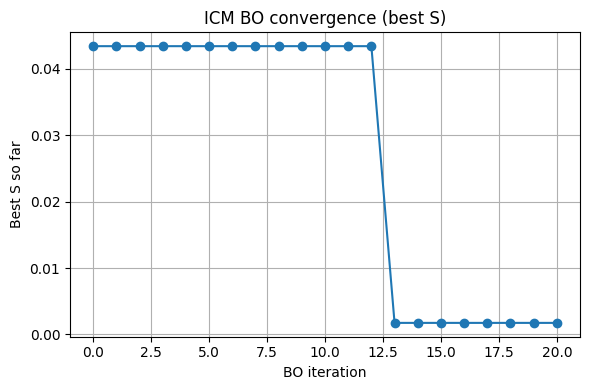

In [19]:
import matplotlib.pyplot as plt
import numpy as np

iters = np.arange(len(S_history))  # 0, 1, 2, ..., N_init+N_BO_ITERS?

plt.figure(figsize=(6,4))
plt.plot(iters, S_history, marker="o")
plt.xlabel("BO iteration")
plt.ylabel("Best S so far")
plt.title("ICM BO convergence (best S)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
# Simple check without accessing constraint directly
noise_values = icm_model.likelihood.noise.data
print(f"Noise values: min={noise_values.min():.6f}, max={noise_values.max():.6f}, mean={noise_values.mean():.6f}")

# Check against expected bounds (from your code: Interval(1e-4, 1.0))
lower_bound = 1e-4
upper_bound = 1.0

at_lower = (noise_values - lower_bound).abs() < 1e-5
at_upper = (noise_values - upper_bound).abs() < 1e-5

if at_lower.any():
    print(f"⚠️  {at_lower.sum()} task(s) at LOWER limit ({lower_bound})")
if at_upper.any():
    print(f"⚠️  {at_upper.sum()} task(s) at UPPER limit ({upper_bound})")
if not at_lower.any() and not at_upper.any():
    print("✓ All noise values within bounds")

Noise values: min=0.000100, max=0.000100, mean=0.000100
⚠️  1 task(s) at LOWER limit (0.0001)


In [23]:
# Simple check without accessing constraint directly
noise_values = icm_model.likelihood.noise.data
print(f"Noise values: min={noise_values.min():.6f}, max={noise_values.max():.6f}, mean={noise_values.mean():.6f}")
print(f"Noise per task: {noise_values.cpu().numpy()}")

# Check against expected bounds (from your code: Interval(1e-4, 1.0))
lower_bound = 1e-4
upper_bound = 1.0

at_lower = (noise_values - lower_bound).abs() < 1e-5
at_upper = (noise_values - upper_bound).abs() < 1e-5

if at_lower.any():
    task_indices = torch.where(at_lower)[0].tolist()
    print(f"⚠️  {at_lower.sum()} task(s) at LOWER limit ({lower_bound}): tasks {task_indices}")
if at_upper.any():
    task_indices = torch.where(at_upper)[0].tolist()
    print(f"⚠️  {at_upper.sum()} task(s) at UPPER limit ({upper_bound}): tasks {task_indices}")
if not at_lower.any() and not at_upper.any():
    print("✓ All noise values within bounds")

Noise values: min=0.000100, max=0.000100, mean=0.000100
Noise per task: [0.0001]
⚠️  1 task(s) at LOWER limit (0.0001): tasks [0]


Best OD index: 32
Best OD vector: [492.67975 582.0218  906.19946 844.51624]
GT OD vector:  [500. 500. 900. 900.]


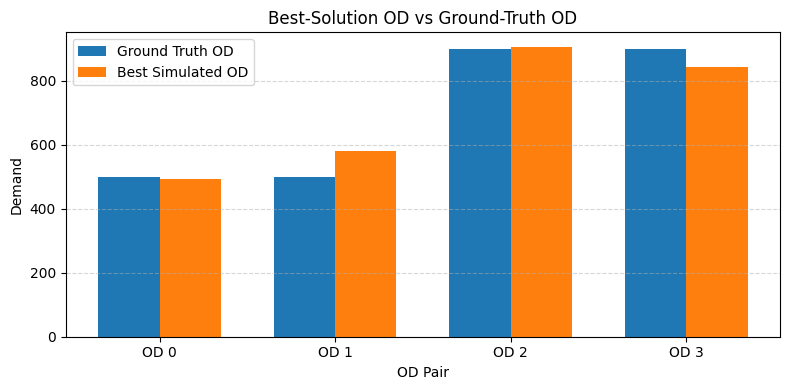

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------
# Find OD vector that achieved the best S
# ------------------------------------------------
best_idx = int(np.argmin(S_obs_history))
best_od = train_X_icm[best_idx].cpu().numpy()  # shape [d]

# Ground truth OD
gt_od = gt_od_df["count"].astype(float).values  # shape [d]

print("Best OD index:", best_idx)
print("Best OD vector:", best_od)
print("GT OD vector: ", gt_od)

# ------------------------------------------------
# Plot comparison
# ------------------------------------------------
labels = [f"OD {i}" for i in range(len(gt_od))]

x = np.arange(len(gt_od))
width = 0.35

plt.figure(figsize=(8,4))
plt.bar(x - width/2, gt_od,  width, label="Ground Truth OD")
plt.bar(x + width/2, best_od, width, label="Best Simulated OD")

plt.xlabel("OD Pair")
plt.ylabel("Demand")
plt.title("Best-Solution OD vs Ground-Truth OD")
plt.xticks(x, labels)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [28]:
# Check the actual noise structure
likelihood = icm_model.likelihood
print(f"Likelihood type: {type(likelihood)}")
print(f"Likelihood num_tasks: {likelihood.num_tasks}")

# Check different noise attributes
print(f"\nNoise attributes:")
print(f"  noise: {likelihood.noise.shape if hasattr(likelihood.noise, 'shape') else 'scalar'}")
print(f"  noise.data: {likelihood.noise.data.shape if hasattr(likelihood.noise.data, 'shape') else 'scalar'}")

# Try accessing task-specific noise if it exists
if hasattr(likelihood, 'task_noises'):
    print(f"  task_noises: {likelihood.task_noises.shape if hasattr(likelihood.task_noises, 'shape') else 'N/A'}")
    print(f"  task_noises.data: {likelihood.task_noises.data}")

# List all attributes
print(f"\nAll likelihood attributes containing 'noise':")
for attr in dir(likelihood):
    if 'noise' in attr.lower():
        try:
            val = getattr(likelihood, attr)
            if not callable(val):
                print(f"  {attr}: {val}")
        except:
            pass

Likelihood type: <class 'gpytorch.likelihoods.multitask_gaussian_likelihood.MultitaskGaussianLikelihood'>
Likelihood num_tasks: 14

Noise attributes:
  noise: torch.Size([1])
  noise.data: torch.Size([1])
  task_noises: torch.Size([14])
  task_noises.data: tensor([2.6746e-04, 1.2113e-04, 1.0100e-04, 1.0077e-04, 1.5680e-04, 1.0062e-04,
        1.0075e-04, 1.0722e-04, 1.5388e-04, 1.6585e-04, 1.3788e-04, 1.0033e-04,
        2.6161e-04, 9.9999e-01])

All likelihood attributes containing 'noise':
  has_global_noise: True
  has_task_noise: True
  noise: tensor([1.0000e-04], grad_fn=<AddBackward0>)
  raw_noise: Parameter containing:
tensor([-30.0085], requires_grad=True)
  raw_task_noises: Parameter containing:
tensor([ -8.6945, -10.7646, -13.8148, -14.0716,  -9.7758, -14.2869, -14.1006,
        -11.8391,  -9.8287,  -9.6280, -10.1808, -14.9266,  -8.7301,  12.1820],
       requires_grad=True)
  task_noises: tensor([2.6746e-04, 1.2113e-04, 1.0100e-04, 1.0077e-04, 1.5680e-04, 1.0062e-04,
       

In [29]:
# Check task-specific noise (this is what you want!)
task_noises = icm_model.likelihood.task_noises.data
num_tasks = len(task_noises)

print(f"Number of tasks (edges): {num_tasks}")
print(f"\nNoise per task:")
print("-" * 50)
for task_idx in range(num_tasks):
    noise_val = task_noises[task_idx].item()
    status = ""
    if abs(noise_val - 1e-4) < 1e-5:
        status = " ⚠️ LOWER LIMIT"
    elif abs(noise_val - 1.0) < 1e-5:
        status = " ⚠️ UPPER LIMIT"
    print(f"  Task {task_idx:3d}: {noise_val:.6f}{status}")

print("-" * 50)
print(f"Summary: min={task_noises.min():.6f}, max={task_noises.max():.6f}, mean={task_noises.mean():.6f}")

# Check limits
lower_bound = 1e-4
upper_bound = 1.0
at_lower = (task_noises - lower_bound).abs() < 1e-5
at_upper = (task_noises - upper_bound).abs() < 1e-5

if at_lower.any():
    task_indices = torch.where(at_lower)[0].tolist()
    print(f"\n⚠️  {at_lower.sum()} task(s) at LOWER limit: tasks {task_indices}")
if at_upper.any():
    task_indices = torch.where(at_upper)[0].tolist()
    print(f"⚠️  {at_upper.sum()} task(s) at UPPER limit: tasks {task_indices}")

Number of tasks (edges): 14

Noise per task:
--------------------------------------------------
  Task   0: 0.000267
  Task   1: 0.000121
  Task   2: 0.000101 ⚠️ LOWER LIMIT
  Task   3: 0.000101 ⚠️ LOWER LIMIT
  Task   4: 0.000157
  Task   5: 0.000101 ⚠️ LOWER LIMIT
  Task   6: 0.000101 ⚠️ LOWER LIMIT
  Task   7: 0.000107 ⚠️ LOWER LIMIT
  Task   8: 0.000154
  Task   9: 0.000166
  Task  10: 0.000138
  Task  11: 0.000100 ⚠️ LOWER LIMIT
  Task  12: 0.000262
  Task  13: 0.999995 ⚠️ UPPER LIMIT
--------------------------------------------------
Summary: min=0.000100, max=0.999995, mean=0.071562

⚠️  6 task(s) at LOWER limit: tasks [2, 3, 5, 6, 7, 11]
⚠️  1 task(s) at UPPER limit: tasks [13]


In [30]:
# Check task 13's error values
task_13_errors = train_Y_icm[:, 13]
print(f"Task 13 error stats:")
print(f"  Mean: {task_13_errors.mean():.6f}")
print(f"  Std: {task_13_errors.std():.6f}")
print(f"  Range: [{task_13_errors.min():.6f}, {task_13_errors.max():.6f}]")
print(f"  Contains NaN: {torch.isnan(task_13_errors).any()}")
print(f"  Contains Inf: {torch.isinf(task_13_errors).any()}")

# Compare with other tasks
other_tasks_mean_std = train_Y_icm[:, [i for i in range(14) if i != 13]].std(dim=1).mean()
print(f"\nTask 13 std: {task_13_errors.std():.6f}")
print(f"Other tasks mean std: {other_tasks_mean_std:.6f}")
print(f"Ratio: {task_13_errors.std() / other_tasks_mean_std:.2f}x")

Task 13 error stats:
  Mean: 1.587842
  Std: 2.185217
  Range: [0.000004, 8.940100]
  Contains NaN: False
  Contains Inf: False

Task 13 std: 2.185217
Other tasks mean std: 0.535483
Ratio: 4.08x


In [31]:
# Check how well task 13's predictions match the shared kernel structure
icm_model.eval()
with torch.no_grad():
    # Get predictions for all tasks at training points
    pred = icm_model(train_X_norm)
    pred_mean = pred.mean  # [N, L]
    pred_std = pred.stddev  # [N, L]
    
    # Check residuals for task 13 vs other tasks
    residuals_13 = (train_Y_icm[:, 13] - pred_mean[:, 13]).abs()
    residuals_others = (train_Y_icm[:, [i for i in range(14) if i != 13]] - 
                       pred_mean[:, [i for i in range(14) if i != 13]]).abs()
    
    print(f"Task 13 prediction quality:")
    print(f"  Mean absolute residual: {residuals_13.mean():.6f}")
    print(f"  Std of residuals: {residuals_13.std():.6f}")
    print(f"  Other tasks mean residual: {residuals_others.mean():.6f}")
    print(f"  Ratio: {residuals_13.mean() / residuals_others.mean():.2f}x")
    
    # Check if task 13's errors are within predicted uncertainty
    coverage_13 = (residuals_13 < pred_std[:, 13]).float().mean()
    coverage_others = (residuals_others < pred_std[:, [i for i in range(14) if i != 13]]).float().mean()
    print(f"\nUncertainty coverage:")
    print(f"  Task 13: {coverage_13:.2%} of residuals within 1 std")
    print(f"  Other tasks: {coverage_others.mean():.2%}")

Task 13 prediction quality:
  Mean absolute residual: 0.549446
  Std of residuals: 0.283294
  Other tasks mean residual: 0.007108
  Ratio: 77.30x

Uncertainty coverage:
  Task 13: 55.00% of residuals within 1 std
  Other tasks: 92.50%


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarni

Edge 13 ID: L15

Ground truth flow for edge 13: 500.00
Edge 13 GT flow: 500.00
Other edges mean GT flow: 1361.54
Edge 13 flow rank: 14 out of 14
⚠️  Edge 13 is a LOW-FLOW edge (bottom 25%) - this could explain high variability

Edge 13 error analysis:
  Error values: min=0.000004, max=8.940100
  Error distribution:
    Mean: 1.587842
    Median: 0.839056
    Std: 2.185217
    CV (std/mean): 1.38

Error vs sample index (check for patterns):


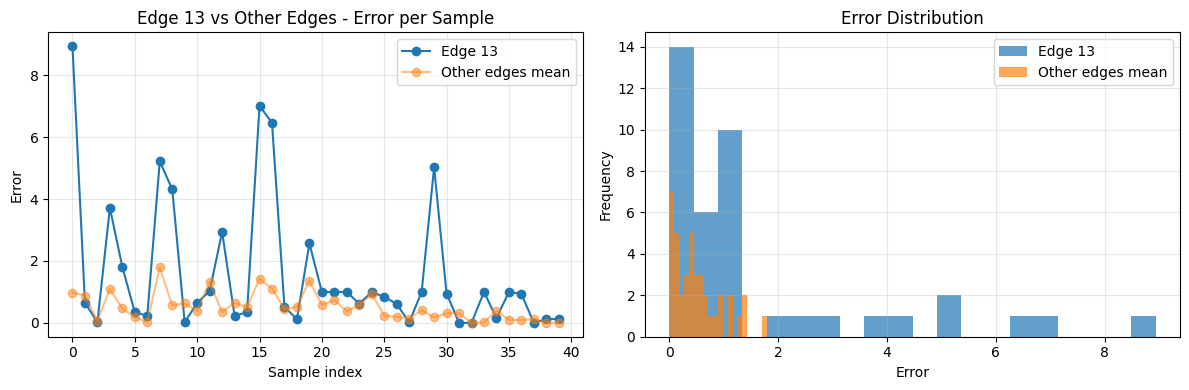


Checking correlation between OD values and edge 13 errors:
  OD pair 0: correlation = 0.795
  OD pair 1: correlation = 0.092
  OD pair 2: correlation = -0.061
  OD pair 3: correlation = -0.015


In [33]:
# If you have edge_ids and gt_edge_data
if 'edge_ids' in locals() or 'edge_ids' in globals():
    edge_13_id = edge_ids[13]
    print(f"Edge 13 ID: {edge_13_id}")
    
    # Check ground truth flow for edge 13
    if 'gt_edge_data' in locals() or 'gt_edge_data' in globals():
        gt_edge_13 = gt_edge_data[gt_edge_data['edge_id'] == edge_13_id]
        if len(gt_edge_13) > 0:
            gt_flow_13 = gt_edge_13['interval_nVehContrib'].values[0]
            print(f"\nGround truth flow for edge 13: {gt_flow_13:.2f}")
            
            # Compare with other edges
            gt_flows_all = [gt_edge_data[gt_edge_data['edge_id'] == eid]['interval_nVehContrib'].values[0] 
                           if len(gt_edge_data[gt_edge_data['edge_id'] == eid]) > 0 else 0
                           for eid in edge_ids]
            print(f"Edge 13 GT flow: {gt_flow_13:.2f}")
            print(f"Other edges mean GT flow: {np.mean([f for i, f in enumerate(gt_flows_all) if i != 13]):.2f}")
            print(f"Edge 13 flow rank: {sorted(gt_flows_all, reverse=True).index(gt_flow_13) + 1} out of {len(gt_flows_all)}")
            
            # Check if it's a low-flow edge (more sensitive to noise)
            if gt_flow_13 < np.percentile([f for i, f in enumerate(gt_flows_all) if i != 13], 25):
                print("⚠️  Edge 13 is a LOW-FLOW edge (bottom 25%) - this could explain high variability")
            elif gt_flow_13 > np.percentile([f for i, f in enumerate(gt_flows_all) if i != 13], 75):
                print("⚠️  Edge 13 is a HIGH-FLOW edge (top 25%) - might have different patterns")

# Check simulated flows for edge 13 across all samples
# If you have simulated flow data
if 'sim_flows' in locals() or hasattr(train_Y_icm, 'sim_flows'):
    # Assuming you can reconstruct or have access to simulated flows
    print("\nSimulated flow patterns for edge 13:")
    # This depends on how you're storing simulated flows
    pass

# Check error patterns - is edge 13 consistently high error or variable?
print(f"\nEdge 13 error analysis:")
print(f"  Error values: min={train_Y_icm[:, 13].min():.6f}, max={train_Y_icm[:, 13].max():.6f}")
print(f"  Error distribution:")
print(f"    Mean: {train_Y_icm[:, 13].mean():.6f}")
print(f"    Median: {train_Y_icm[:, 13].median():.6f}")
print(f"    Std: {train_Y_icm[:, 13].std():.6f}")
print(f"    CV (std/mean): {train_Y_icm[:, 13].std() / train_Y_icm[:, 13].mean():.2f}")

# Check if errors are correlated with OD values
# High error might correlate with certain OD patterns
print(f"\nError vs sample index (check for patterns):")
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_Y_icm[:, 13].cpu().numpy(), 'o-', label='Edge 13')
plt.plot(train_Y_icm[:, [i for i in range(14) if i != 13]].mean(dim=1).cpu().numpy(), 
         'o-', alpha=0.5, label='Other edges mean')
plt.xlabel('Sample index')
plt.ylabel('Error')
plt.title('Edge 13 vs Other Edges - Error per Sample')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(train_Y_icm[:, 13].cpu().numpy(), bins=20, alpha=0.7, label='Edge 13')
plt.hist(train_Y_icm[:, [i for i in range(14) if i != 13]].mean(dim=1).cpu().numpy(), 
         bins=20, alpha=0.7, label='Other edges mean')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Check if edge 13 errors correlate with specific OD values
# (if you have access to the OD values used)
if 'train_X_icm' in locals() or 'train_X' in locals():
    od_vals = train_X_icm if 'train_X_icm' in locals() else train_X
    print(f"\nChecking correlation between OD values and edge 13 errors:")
    for od_idx in range(od_vals.shape[1]):
        corr = np.corrcoef(od_vals[:, od_idx].cpu().numpy(), 
                          train_Y_icm[:, 13].cpu().numpy())[0, 1]
        print(f"  OD pair {od_idx}: correlation = {corr:.3f}")

Edge 13 ID: L4

Ground truth flow for edge 13: 1800.00
Edge 13 GT flow: 1800.00
Other edges mean GT flow: 1261.54
Edge 13 flow rank: 1 out of 14
⚠️  Edge 13 is a HIGH-FLOW edge (top 25%) - might have different patterns

Edge 13 error analysis:
  Error values: min=0.000004, max=8.940100
  Error distribution:
    Mean: 1.587842
    Median: 0.839056
    Std: 2.185217
    CV (std/mean): 1.38

Error vs sample index (check for patterns):


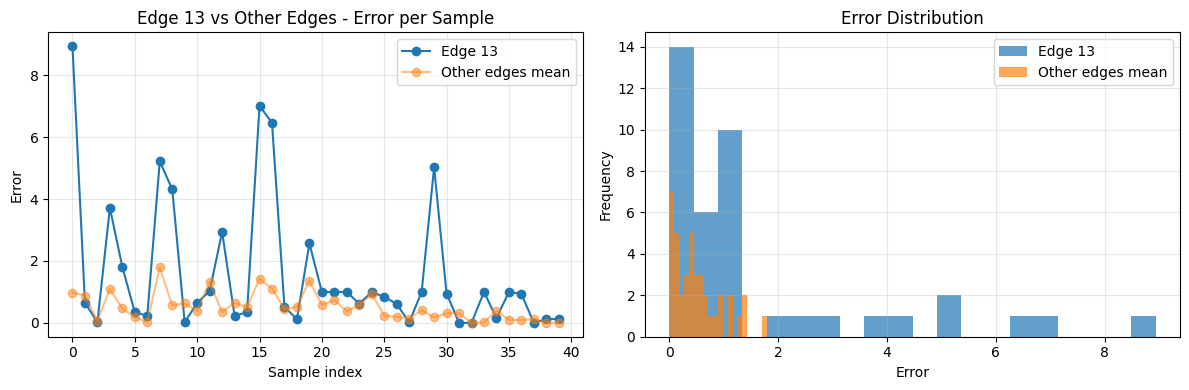


Checking correlation between OD values and edge 13 errors:
  OD pair 0: correlation = 0.795
  OD pair 1: correlation = 0.092
  OD pair 2: correlation = -0.061
  OD pair 3: correlation = -0.015


In [ ]:
# If you have edge_ids and gt_edge_data
if 'edge_ids' in locals() or 'edge_ids' in globals():
    edge_13_id = edge_ids[13]
    print(f"Edge 13 ID: {edge_13_id}")
    
    # Check ground truth flow for edge 13
    if 'gt_edge_data' in locals() or 'gt_edge_data' in globals():
        gt_edge_13 = gt_edge_data[gt_edge_data['edge_id'] == edge_13_id]
        if len(gt_edge_13) > 0:
            gt_flow_13 = gt_edge_13['interval_nVehContrib'].values[0]
            print(f"\nGround truth flow for edge 13: {gt_flow_13:.2f}")
            
            # Compare with other edges
            gt_flows_all = [gt_edge_data[gt_edge_data['edge_id'] == eid]['interval_nVehContrib'].values[0] 
                           if len(gt_edge_data[gt_edge_data['edge_id'] == eid]) > 0 else 0
                           for eid in edge_ids]
            print(f"Edge 13 GT flow: {gt_flow_13:.2f}")
            print(f"Other edges mean GT flow: {np.mean([f for i, f in enumerate(gt_flows_all) if i != 13]):.2f}")
            print(f"Edge 13 flow rank: {sorted(gt_flows_all, reverse=True).index(gt_flow_13) + 1} out of {len(gt_flows_all)}")
            
            # Check if it's a low-flow edge (more sensitive to noise)
            if gt_flow_13 < np.percentile([f for i, f in enumerate(gt_flows_all) if i != 13], 25):
                print("⚠️  Edge 13 is a LOW-FLOW edge (bottom 25%) - this could explain high variability")
            elif gt_flow_13 > np.percentile([f for i, f in enumerate(gt_flows_all) if i != 13], 75):
                print("⚠️  Edge 13 is a HIGH-FLOW edge (top 25%) - might have different patterns")

# Check simulated flows for edge 13 across all samples
# If you have simulated flow data
if 'sim_flows' in locals() or hasattr(train_Y_icm, 'sim_flows'):
    # Assuming you can reconstruct or have access to simulated flows
    print("\nSimulated flow patterns for edge 13:")
    # This depends on how you're storing simulated flows
    pass

# Check error patterns - is edge 13 consistently high error or variable?
print(f"\nEdge 13 error analysis:")
print(f"  Error values: min={train_Y_icm[:, 13].min():.6f}, max={train_Y_icm[:, 13].max():.6f}")
print(f"  Error distribution:")
print(f"    Mean: {train_Y_icm[:, 13].mean():.6f}")
print(f"    Median: {train_Y_icm[:, 13].median():.6f}")
print(f"    Std: {train_Y_icm[:, 13].std():.6f}")
print(f"    CV (std/mean): {train_Y_icm[:, 13].std() / train_Y_icm[:, 13].mean():.2f}")

# Check if errors are correlated with OD values
# High error might correlate with certain OD patterns
print(f"\nError vs sample index (check for patterns):")
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_Y_icm[:, 13].cpu().numpy(), 'o-', label='Edge 13')
plt.plot(train_Y_icm[:, [i for i in range(14) if i != 13]].mean(dim=1).cpu().numpy(), 
         'o-', alpha=0.5, label='Other edges mean')
plt.xlabel('Sample index')
plt.ylabel('Error')
plt.title('Edge 13 vs Other Edges - Error per Sample')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(train_Y_icm[:, 13].cpu().numpy(), bins=20, alpha=0.7, label='Edge 13')
plt.hist(train_Y_icm[:, [i for i in range(14) if i != 13]].mean(dim=1).cpu().numpy(), 
         bins=20, alpha=0.7, label='Other edges mean')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Check if edge 13 errors correlate with specific OD values
# (if you have access to the OD values used)
if 'train_X_icm' in locals() or 'train_X' in locals():
    od_vals = train_X_icm if 'train_X_icm' in locals() else train_X
    print(f"\nChecking correlation between OD values and edge 13 errors:")
    for od_idx in range(od_vals.shape[1]):
        corr = np.corrcoef(od_vals[:, od_idx].cpu().numpy(), 
                          train_Y_icm[:, 13].cpu().numpy())[0, 1]
        print(f"  OD pair {od_idx}: correlation = {corr:.3f}")

Edge 1 ID: L14

Ground truth flow for edge 1: 1800.00
Edge 1 GT flow: 1800.00
Other edges mean GT flow: 1261.54
Edge 1 flow rank: 1 out of 14
⚠️  Edge 1 is a HIGH-FLOW edge (top 25%) - might have different patterns

Edge 1 error analysis:
  Error values: min=0.000008, max=1.493827
  Error distribution:
    Mean: 0.273046
    Median: 0.144823
    Std: 0.352265
    CV (std/mean): 1.29

Error vs sample index (check for patterns):


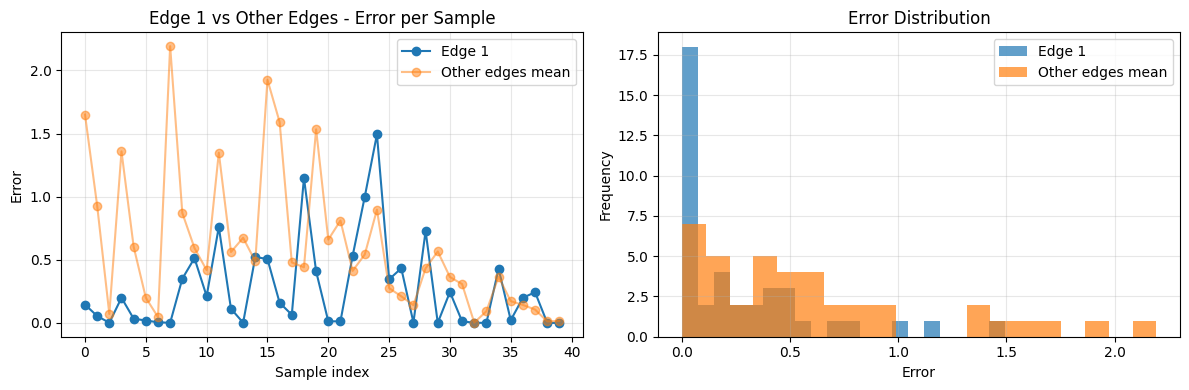


Checking correlation between OD values and edge 1 errors:
  OD pair 0: correlation = -0.085
  OD pair 1: correlation = 0.052
  OD pair 2: correlation = 0.164
  OD pair 3: correlation = 0.130


In [44]:
# Investigate a specific edge (change edge_idx to any edge number 0-13)
edge_idx = 1 # Change this to investigate different edges (e.g., 0, 1, 2, etc.)

# If you have edge_ids and gt_edge_data
if 'edge_ids' in locals() or 'edge_ids' in globals():
    edge_id = edge_ids[edge_idx]
    print(f"Edge {edge_idx} ID: {edge_id}")
    
    # Check ground truth flow for this edge
    if 'gt_edge_data' in locals() or 'gt_edge_data' in globals():
        gt_edge = gt_edge_data[gt_edge_data['edge_id'] == edge_id]
        if len(gt_edge) > 0:
            gt_flow = gt_edge['interval_nVehContrib'].values[0]
            print(f"\nGround truth flow for edge {edge_idx}: {gt_flow:.2f}")
            
            # Compare with other edges
            gt_flows_all = [gt_edge_data[gt_edge_data['edge_id'] == eid]['interval_nVehContrib'].values[0] 
                           if len(gt_edge_data[gt_edge_data['edge_id'] == eid]) > 0 else 0
                           for eid in edge_ids]
            print(f"Edge {edge_idx} GT flow: {gt_flow:.2f}")
            print(f"Other edges mean GT flow: {np.mean([f for i, f in enumerate(gt_flows_all) if i != edge_idx]):.2f}")
            print(f"Edge {edge_idx} flow rank: {sorted(gt_flows_all, reverse=True).index(gt_flow) + 1} out of {len(gt_flows_all)}")
            
            # Check if it's a low-flow edge (more sensitive to noise)
            if gt_flow < np.percentile([f for i, f in enumerate(gt_flows_all) if i != edge_idx], 25):
                print(f"⚠️  Edge {edge_idx} is a LOW-FLOW edge (bottom 25%) - this could explain high variability")
            elif gt_flow > np.percentile([f for i, f in enumerate(gt_flows_all) if i != edge_idx], 75):
                print(f"⚠️  Edge {edge_idx} is a HIGH-FLOW edge (top 25%) - might have different patterns")

# Check error patterns - is this edge consistently high error or variable?
print(f"\nEdge {edge_idx} error analysis:")
print(f"  Error values: min={train_Y_icm[:, edge_idx].min():.6f}, max={train_Y_icm[:, edge_idx].max():.6f}")
print(f"  Error distribution:")
print(f"    Mean: {train_Y_icm[:, edge_idx].mean():.6f}")
print(f"    Median: {train_Y_icm[:, edge_idx].median():.6f}")
print(f"    Std: {train_Y_icm[:, edge_idx].std():.6f}")
print(f"    CV (std/mean): {train_Y_icm[:, edge_idx].std() / train_Y_icm[:, edge_idx].mean():.2f}")

# Check if errors are correlated with OD values
# High error might correlate with certain OD patterns
print(f"\nError vs sample index (check for patterns):")
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_Y_icm[:, edge_idx].cpu().numpy(), 'o-', label=f'Edge {edge_idx}')
plt.plot(train_Y_icm[:, [i for i in range(14) if i != edge_idx]].mean(dim=1).cpu().numpy(), 
         'o-', alpha=0.5, label='Other edges mean')
plt.xlabel('Sample index')
plt.ylabel('Error')
plt.title(f'Edge {edge_idx} vs Other Edges - Error per Sample')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(train_Y_icm[:, edge_idx].cpu().numpy(), bins=20, alpha=0.7, label=f'Edge {edge_idx}')
plt.hist(train_Y_icm[:, [i for i in range(14) if i != edge_idx]].mean(dim=1).cpu().numpy(), 
         bins=20, alpha=0.7, label='Other edges mean')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Check if edge errors correlate with specific OD values
# (if you have access to the OD values used)
if 'train_X_icm' in locals() or 'train_X' in locals():
    od_vals = train_X_icm if 'train_X_icm' in locals() else train_X
    print(f"\nChecking correlation between OD values and edge {edge_idx} errors:")
    for od_idx in range(od_vals.shape[1]):
        corr = np.corrcoef(od_vals[:, od_idx].cpu().numpy(), 
                          train_Y_icm[:, edge_idx].cpu().numpy())[0, 1]
        print(f"  OD pair {od_idx}: correlation = {corr:.3f}")

In [43]:
# Compare all edges side-by-side
print("Comparing all edges:\n")
print(f"{'Edge':<6} {'GT Flow':<10} {'Error Mean':<12} {'Error Std':<12} {'CV':<8}")
print("-" * 60)

if 'edge_ids' in locals() or 'edge_ids' in globals():
    if 'gt_edge_data' in locals() or 'gt_edge_data' in globals():
        for i in range(14):
            edge_id = edge_ids[i]
            gt_edge = gt_edge_data[gt_edge_data['edge_id'] == edge_id]
            gt_flow = gt_edge['interval_nVehContrib'].values[0] if len(gt_edge) > 0 else 0
            err_mean = train_Y_icm[:, i].mean().item()
            err_std = train_Y_icm[:, i].std().item()
            cv = err_std / err_mean if err_mean > 0 else 0
            print(f"{i:<6} {gt_flow:<10.2f} {err_mean:<12.6f} {err_std:<12.6f} {cv:<8.2f}")

Comparing all edges:

Edge   GT Flow    Error Mean   Error Std    CV      
------------------------------------------------------------
0      1800.00    0.273046     0.352265     1.29    
1      1800.00    0.273046     0.352265     1.29    
2      1800.00    0.273046     0.352265     1.29    
3      1400.00    0.338379     0.505873     1.49    
4      1400.00    0.450090     0.515383     1.15    
5      1400.00    0.450090     0.515383     1.15    
6      1400.00    0.338379     0.505873     1.49    
7      1400.00    0.338379     0.505873     1.49    
8      1400.00    0.450090     0.515383     1.15    
9      1000.00    0.967213     1.552583     1.61    
10     1000.00    0.967213     1.552583     1.61    
11     1000.00    0.967213     1.552583     1.61    
12     900.00     0.561074     0.485233     0.86    
13     500.00     1.587842     2.185217     1.38    


## comparing scalar gp with icm 